In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import pandas
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm


c:\Users\saika\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\saika\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\saika\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import sys 
sys.path.append("C://Users//saika//Downloads")

In [3]:
from data_management import LSMMData
import json

with open('test.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings
 
print(tables['structural']['pre_cell'])
print(tables['structural']['post_cell'])
print(tables['structural']['synapse'])
 
pt_root_id = tables['structural']['pre_cell'].iloc[1]['pt_root_id']
print("Connectome Index.  Should be 41:", mappings['pt_root_id_to_connectome_index'][pt_root_id])


     index      id          pt_root_id  pt_position_x  pt_position_y  \
0        9  293764  864691132625300120         878665         697702   
1       41  295576  864691132710501931         842193         737122   
2       62  278405  864691132830575876         737898         601710   
3       76  293733  864691132616354625         858877         700030   
4       85  307952  864691132999200949         867646         840563   
..     ...     ...                 ...            ...            ...   
847   8764  371302  864691132849454803         958050         629957   
848   8769  385115  864691132679146333         975354         850418   
849   8773  383491  864691132763271347         928872         797418   
850   8790  351167  864691132579592205         927863         548865   
851   8794  277788  864691132653866455         853833         547235   

     pt_position_z classification_system cell_type status_axon  \
0           245475            excitatory        4P    extended   
1  

In [4]:
def calc_ground_truth(pre_cells, synapse, post_cells, use_sizes=False):
    pre_cell_pt_index = pre_cells['pt_root_id']
    post_cell_pt_index = post_cells['pt_root_id']
    synapses = synapse[(synapse['pre_pt_root_id'].isin(pre_cells['pt_root_id'])) & (synapse['post_pt_root_id'].isin(post_cells['pt_root_id']))]
    pre_cell_pt_index = pre_cell_pt_index.to_list()
    post_cell_pt_index = post_cell_pt_index.to_list()

    synapse_connectome = np.zeros((len(pre_cells), len(post_cells)))
    for synapse in tqdm(range(len(synapses))):
        preidx = pre_cell_pt_index.index(synapses.iloc[synapse]['pre_pt_root_id'])
        postidx = post_cell_pt_index.index(synapses.iloc[synapse]['post_pt_root_id'])
        if use_sizes:
            synapse_connectome[preidx,postidx] += synapses.iloc[synapse]['size']
        else:
            synapse_connectome[preidx,postidx] += 1
    return synapse_connectome

In [5]:

cell_table = tables['structural']['pre_cell']



# # cell_table = cell_table.query('soma_layer == "23"')[['pt_root_id', 'soma_layer']].reset_index()
#cell_table['connectome_index'] = cell_table['conn']

# cell_table['connectome_index'] = cell_table.index
# cell_table = cell_table.query('cell_type == "PYC"')[['connectome_index', 'pt_root_id', 'soma_layer']].reset_index()

synapse_table = tables['structural']['synapse'] #pandas.read_feather('C://Users//saika//Downloads//v1dd_with_additional_coregistered_neurons_Julian_latest_now//v1dd_with_additional_coregistered_neurons_Julian_latest//additional_coregistered_neurons//synapse_table_v1dd_shortened_additional_cells.feather')
weight_matrix = calc_ground_truth(cell_table, synapse_table, cell_table, use_sizes=True)
adjacency_matrix = weight_matrix.clip(0,1)
np.fill_diagonal(weight_matrix, 0)
#pyr_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

100%|██████████| 163052/163052 [03:59<00:00, 681.51it/s]


In [6]:
weight_matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 644.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ..., 306.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [7]:
mappings.keys()

dict_keys(['functional_indexes_by_assembly', 'assemblies_by_functional_index', 'pt_root_id_to_connectome_index', 'connectome_index_to_root_id', 'roi_id_to_pt_root_id', 'functional_index_to_roi_id', 'assemblies_by_roi_id', 'assemblies_by_pt_root_id', 'assemblies_by_connectome_index'])

In [8]:
cell_table

,index,id,pt_root_id,pt_position_x,pt_position_y,pt_position_z,classification_system,cell_type,status_axon,pt_position_x_trafo,...,layer,dist_pia,dist_1-23,dist_23-4,dist_4-5,dist_5-6,dist_WM,full_dendrite,cell_type_v2,connectome_index
0,9,293764,864691132625300120,878665,697702,245475,excitatory,4P,extended,-17654.153169,...,L4,348299.261582,248299.261582,78299.261582,51700.738418,201700.738418,401700.738418,True,4P,0
1,41,295576,864691132710501931,842193,737122,325260,inhibitory,ProxTC,extended,-67856.489452,...,L5,407818.941194,307818.941194,137818.941194,7818.941194,142181.058806,342181.058806,True,ProxTC-L5,1
2,62,278405,864691132830575876,737898,601710,294075,inhibitory,DistTC,extended,-145995.980100,...,L23,269521.726886,169521.726886,478.273114,130478.273114,280478.273114,480478.273114,True,DistTC-L23,2
3,76,293733,864691132616354625,858877,700030,240210,inhibitory,InhTC,extended,-37633.019997,...,L4,349231.413669,249231.413669,79231.413669,50768.586331,200768.586331,400768.586331,True,InhTC-L4,3
4,85,307952,864691132999200949,867646,840563,262935,excitatory,5P,extended,-69027.465946,...,L5,490673.563262,390673.563262,220673.563262,90673.563262,59326.436738,259326.436738,True,5P,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,8764,371302,864691132849454803,958050,629957,382545,inhibitory,ProxTC,extended,67043.559779,...,L4,319323.746587,219323.746587,49323.746587,80676.253413,230676.253413,430676.253413,True,ProxTC-L4,847
848,8769,385115,864691132679146333,975354,850418,394650,excitatory,6P,extended,17544.597851,...,L5,534890.730711,434890.730711,264890.730711,134890.730711,15109.269289,215109.269289,True,6P,848
849,8773,383491,864691132763271347,928872,797418,316125,excitatory,5P,extended,3578.299784,...,L5,463037.004450,363037.004450,193037.004450,63037.004450,86962.995550,286962.995550,True,5P,849
850,8790,351167,864691132579592205,927863,548865,192105,inhibitory,ProxTC,extended,51726.443534,...,L23,190364.527692,90364.527692,79635.472308,209635.472308,359635.472308,559635.472308,False,ProxTC-L23,850


In [9]:
l1 = cell_table.query('layer  == "L1"')
l23 = cell_table.query('layer  == "L23"')
l4 = cell_table.query('layer  == "L4"')
l5 = cell_table.query('layer  == "L5"')
l6 = cell_table.query('layer  == "L6"')

In [ ]:
#check layer dataframes
#l1

Getting co-ordinates for marking Layers in Connectome Network

In [465]:
max_p2_l1 = float('-inf')
for idx, sublist in enumerate(l1['pt_position_y']):
    pos2 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l1:
        max_p2_l1 = pos2
print("L1:", max_p2_l1)

max_p2_l23 = float('-inf')
for idx, sublist in enumerate(l23['pt_position_y']):
    pos2 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l23:
        max_p2_l23 = pos2
print("L23:",max_p2_l23)

max_p2_l4 = float('-inf')
for idx, sublist in enumerate(l4['pt_position_y']):
    pos2 = sublist # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l4:
        max_p2_l4 = pos2
print("L4:",max_p2_l4)

max_p2_l5 = float('-inf')
for idx, sublist in enumerate(l5['pt_position_y']):
    pos2 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l5:
        max_p2_l5 = pos2
print("L5:",max_p2_l5)

max_p2_l6 = float('-inf')
for idx, sublist in enumerate(l6['pt_position_y']):
    pos2 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l6:
        max_p2_l6 = pos2
print("L6:",max_p2_l6)

L1: 469790
L23: 649900
L4: 760946
L5: 890693
L6: 1056369


In [317]:
'''coords = np.load("C://Users//saika//Downloads//transformed_coordinates.npy")'''

In [15]:
#checking psd sizes
'''summed_psd_size = []
for idx,connections  in enumerate(weight_matrix):
    for conn_idx,conn_value in enumerate(connections):
        summed_psd_size.append(conn_value)'''

In [ ]:
'''for idx,sublist1, sublist2 in zip(cell_table['connectome_index'], cell_table['pt_position_x'], cell_table['pt_position_y']):
   print(idx, sublist1, sublist2)'''

In [18]:
np.max(weight_matrix)

53280.0

In [ ]:
'''for idx,connections  in enumerate(weight_matrix):
    for conn_idx,conn_value in enumerate(connections):
        print(conn_idx, conn_value)'''

SETTING EDGE COLORS

In [460]:


G = nx.Graph()

for idx, pos1, pos2 in zip(cell_table['connectome_index'], cell_table['pt_position_x'], cell_table['pt_position_y']):
   # pos1, pos2, pos3 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    # pos1_rounded = round(pos1, 2)
    # pos2_rounded = round(pos2, 2)
    G.add_node(idx, pos = [pos1, pos2])  


for idx,connections  in enumerate(weight_matrix):
    for conn_idx,conn_value in enumerate(connections):
        if 15000 < conn_value <= 18000:
            G.add_edge(idx,conn_idx, weight = 0.2, color = 'yellow', label='Connection 1')
        elif 18000 < conn_value <= 30000:
            G.add_edge(idx,conn_idx, weight = 0.8, color = 'orange', label='Connection 2')
        elif 30000 < conn_value <= 45000:
            G.add_edge(idx,conn_idx, weight = 1.2, color = 'cyan', label='Connection 3')
        elif conn_value> 45000:
            G.add_edge(idx,conn_idx, weight = 2, color = 'm', label='Connection 4')
   # if idx>0:
   #     G.add_edge(idx-1, idx)  # Adding edge between consecutive nodes




In [461]:
colors = nx.get_edge_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()


SETTING NODE COLORS

In [458]:
color_map = []
assembly_map = []
idx = []
no_assembly = ['No A']
for node in G.nodes():
    if node in  mappings['assemblies_by_connectome_index'].keys():
                   val = mappings['assemblies_by_connectome_index'][node]
                   if val == no_assembly:
                         
                          color_map.append('red')
                          #assembly_map.append('black')
                   else:
                            #print(nik)
                            color_map.append('green')  
                            
            
            #idx.append(node)
    else:
            color_map.append('grey')
            #idx.append(node)


In [275]:
len(color_map)

852

**CONNECTOME NETWORK FIGURE**

In [466]:
pos = nx.get_node_attributes(G, 'pos')


In [335]:
from matplotlib.lines import Line2D

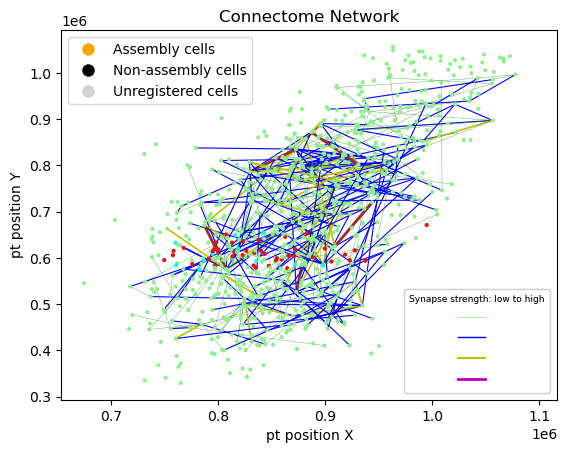

In [346]:
##TRIAL FIGURE
'''
fig, ax = plt.subplots()



nx.draw(G, pos,
        width=list(weights),
        edge_color=colors, 
        with_labels=False,node_size=4,
        node_color=color_map, ax= ax)
limits=plt.axis('on') # turns on axis



# Create custom legend handles for nodes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Assembly cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Non-assembly cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=10, label='Unregistered cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='green', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='b', markersize=10, label='Non-assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='y', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='m', markersize=10, label='Non-assembly cells')
]

# Add the legend to the plot
node_legend = ax.legend(handles=legend_elements, loc='upper left')

# Create custom legend handles for edges
edge_legend_elements = [
    Line2D([0], [0], color='lightgreen', lw=0.5),
    Line2D([0], [0], color='b', lw=1),
    Line2D([0], [0], color='y', lw=1.5),
    Line2D([0], [0], color='m', lw=2)
]

# Add the legend to the plot
edge_legend = ax.legend(handles=edge_legend_elements, loc='lower right', title='Synapse strength: low to high',title_fontsize = 6.5, bbox_to_anchor=(1, 0))

# Show the plot
#ax.invert_yaxis()
ax.add_artist(node_legend)  # Add the node legend first
ax.add_artist(edge_legend)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.xlabel('pt position X')
plt.ylabel('pt position Y')
plt.title('Connectome Network')
plt.show()'''

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


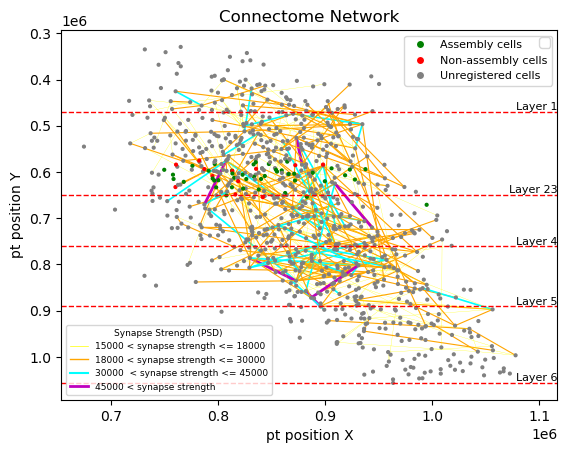

In [467]:
fig, ax = plt.subplots()


nx.draw(G, pos,
        width=list(weights),
        edge_color=colors, 
        with_labels=False,node_size=4,
        node_color=color_map, ax= ax)
limits=plt.axis('on') # turns on axis

#-------Add layers to plot----------
y_values = [max_p2_l1, max_p2_l23,max_p2_l4,  max_p2_l5,  max_p2_l6]
labels = ['Layer 1', 'Layer 23', 'Layer 4', 'Layer 5', 'Layer 6']

ax = plt.gca()
# Add horizontal lines and labels
for y, label in zip(y_values, labels):
    ax.axhline(y=y, color='r', linestyle='--', linewidth=1)
    #x = ax.get_x()
    x_min, x_max = ax.get_xlim()
    ax.text(x_max,y, label, color='black', fontsize=8, ha='right', va='bottom')

#---------------------------------

# Create custom legend handles for nodes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=6, label='Assembly cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=6, label='Non-assembly cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=6, label='Unregistered cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='green', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='b', markersize=10, label='Non-assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='y', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='m', markersize=10, label='Non-assembly cells')
]

# Add the legend to the plot
node_legend = ax.legend(handles=legend_elements, loc='upper right', fontsize='8' )

# Create custom legend handles for edges
edge_legend_elements = [
    Line2D([0], [0], color='yellow', label = '15000 < synapse strength <= 18000' ,  lw=0.5),
    Line2D([0], [0], color='orange',label = '18000 < synapse strength <= 30000' ,lw=1),
    Line2D([0], [0], color='cyan',label = '30000  < synapse strength <= 45000' ,lw=1.5),
    Line2D([0], [0], color='m', label = '45000 < synapse strength', lw=2)
]

# Add the legend to the plot
edge_legend = ax.legend(handles=edge_legend_elements, loc='lower left',title='Synapse Strength (PSD)',fontsize = 6.5,title_fontsize = 6.5)



#########trial method for text legend combo#############
# ax.annotate('1: Conn 1: ', xy=(1.05, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),
# ax.annotate('-'*2, xy=(1.24, 0.9), xycoords='axes fraction', color='red', fontsize=12, ha='left', va='center'),
# ax.annotate('1: Conn 1: ', xy=(1.5, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),


# Show the plot

#add both node and edge legends
ax.add_artist(node_legend)  # Add the node legend first
ax.add_artist(edge_legend)

#invert axis to get Layer 6 at bottom
ax.invert_yaxis()

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.legend(markerfirst = False)

plt.xlabel('pt position X')
plt.ylabel('pt position Y')
plt.title('Connectome Network')
plt.autoscale()
plt.savefig('connectivity_plot_revised1.png', dpi=1200) 
plt.show()